In [ ]:
# ECGR 4106 HW3
# Author: Lucas Therrien
# Student ID #801122089
# GitHub Link: https://github.com/lucastherrien/ECGR4106HW3



##_________________________________________##
## Setup
##_________________________________________##

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics import Accuracy
from torch import optim
from torchsummary import summary
#Suppress all warnings because they annoy me
import warnings
warnings.filterwarnings("ignore")

In [ ]:
##_________________________________________##
## Problem 1
##_________________________________________##

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,),)])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = dataloader.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valloader = dataloader.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
def build_vgg_net(arch, num_classes=10):
    conv_blks = []
    for (num_convs, out_channels) in arch:
        conv_blks.append(vgg_block(num_convs, out_channels))
    model = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    return model

In [17]:
VGG_11 = build_vgg_net(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
VGG_11.to(device)
#summary(VGG_11,(3,64,64))

Sequential(
  (0): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6):

In [18]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(VGG_11.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG_11(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = VGG_11(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 1.3381380328284505 val: 1.1910769855900176 val acc: 0.5845939517021179
 epoch[2] losses train: 0.8505129061086708 val: 0.8529557840080019 val acc: 0.7194466590881348
 epoch[3] losses train: 0.6563444059446949 val: 0.7495834643294097 val acc: 0.7505971193313599
 epoch[4] losses train: 0.5245591435972077 val: 0.7841382089314187 val acc: 0.7492038607597351
 epoch[5] losses train: 0.42637547650529295 val: 0.7116985620966383 val acc: 0.7774681448936462
 epoch[6] losses train: 0.3363362590846656 val: 0.7694081159154321 val acc: 0.765625
 epoch[7] losses train: 0.2684330184708166 val: 0.7322941004850303 val acc: 0.7877189517021179
 epoch[8] losses train: 0.21599552864709015 val: 0.8236412037709716 val acc: 0.7846337556838989
 epoch[9] losses train: 0.1747319890505365 val: 1.071438263176353 val acc: 0.749502420425415
 epoch[10] losses train: 0.14712382314483757 val: 0.9969732856294912 val acc: 0.7706011533737183
 epoch[11] losses train: 0.11107162931038404 val: 0.714351

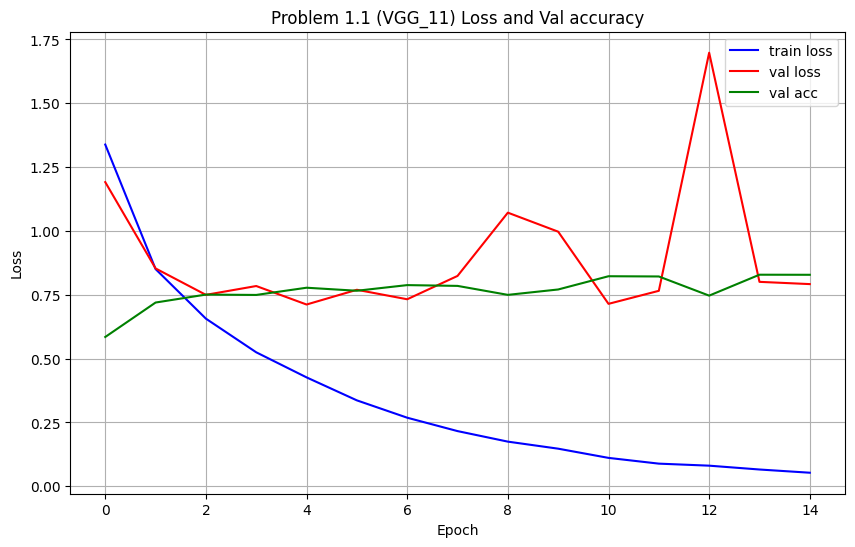

In [35]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 1.1 (VGG_11) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [65]:
VGG_16 = build_vgg_net(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
VGG_16.to(device)
#summary(VGG_16,(3,64,64))

Sequential(
  (0): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): 

In [66]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(VGG_16.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG_16(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = VGG_16(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 1.4151036544986393 val: 1.6837258232626946 val acc: 0.4782046377658844
 epoch[2] losses train: 0.8603634637639955 val: 0.8849867043221832 val acc: 0.7140724658966064
 epoch[3] losses train: 0.6540716616317744 val: 0.7126896607268388 val acc: 0.7725915908813477
 epoch[4] losses train: 0.525597366130413 val: 0.810468233125225 val acc: 0.7200437784194946
 epoch[5] losses train: 0.42613659353207445 val: 1.0346585645037851 val acc: 0.702627420425415
 epoch[6] losses train: 0.35296033217054806 val: 0.7308953343682988 val acc: 0.7818471193313599
 epoch[7] losses train: 0.288313580776953 val: 0.6421434418980483 val acc: 0.8072253465652466
 epoch[8] losses train: 0.2298994335462637 val: 0.5551635321158512 val acc: 0.8382762670516968
 epoch[9] losses train: 0.18952456653794592 val: 0.5924875670747393 val acc: 0.8326035141944885
 epoch[10] losses train: 0.1560071997292092 val: 0.6570342455510121 val acc: 0.8300159573554993
 epoch[11] losses train: 0.12490383403189957 val: 

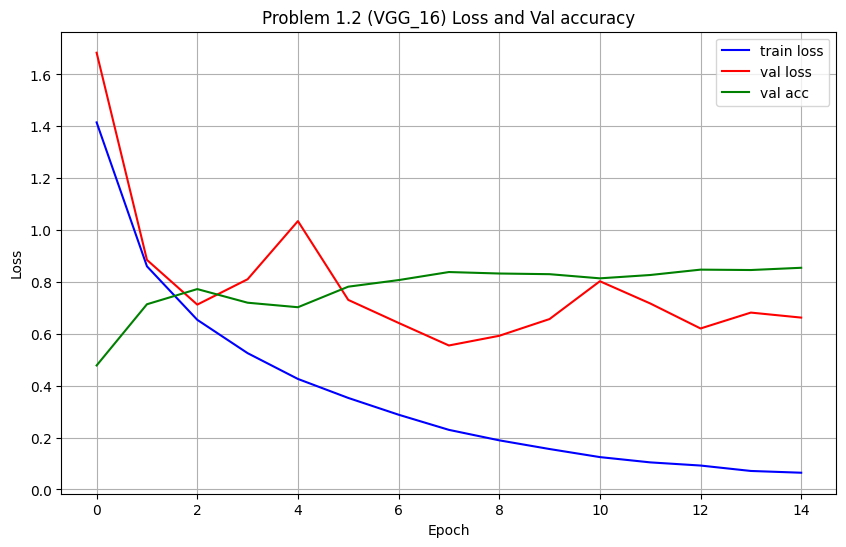

In [67]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 1.2 (VGG_16) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [68]:
VGG_19 = build_vgg_net(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
VGG_19.to(device)
#summary(VGG_16,(3,64,64))

Sequential(
  (0): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): 

In [69]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(VGG_19.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG_19(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = VGG_19(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 1.675753408228345 val: 1.8633395349903472 val acc: 0.39032644033432007
 epoch[2] losses train: 1.0612270563002437 val: 1.0832870245739152 val acc: 0.646994411945343
 epoch[3] losses train: 0.799159451709379 val: 0.8311725118357665 val acc: 0.7362659573554993
 epoch[4] losses train: 0.640061926658806 val: 0.7801343458852951 val acc: 0.7598527073860168
 epoch[5] losses train: 0.5281586575386165 val: 0.7550272079789715 val acc: 0.7788614630699158
 epoch[6] losses train: 0.44014795107381116 val: 0.6008327755199117 val acc: 0.8099124431610107
 epoch[7] losses train: 0.3692728960815141 val: 0.6953994861453962 val acc: 0.7893112897872925
 epoch[8] losses train: 0.30561319354664335 val: 0.5773931755002137 val acc: 0.831011176109314
 epoch[9] losses train: 0.26274312639137365 val: 0.6323128547638085 val acc: 0.818471372127533
 epoch[10] losses train: 0.21663818939510363 val: 0.5609560960986811 val acc: 0.8440485596656799
 epoch[11] losses train: 0.185583857275174 val: 0.

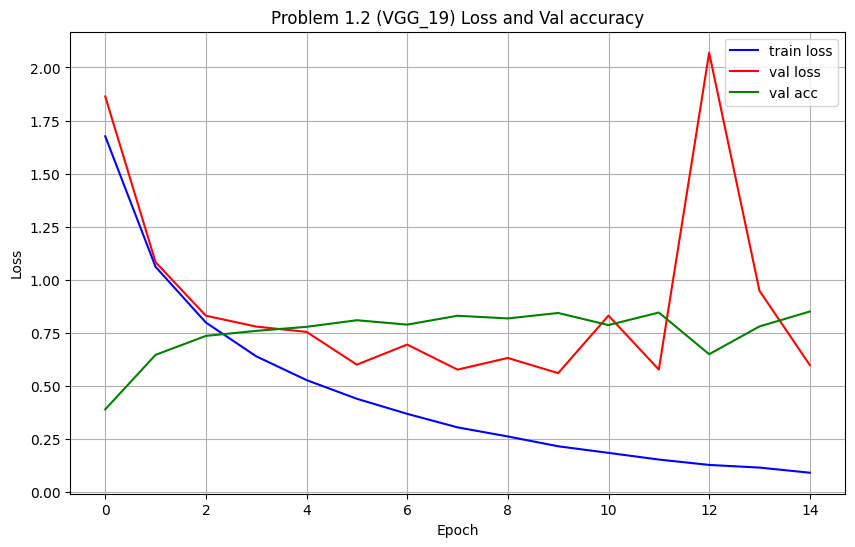

In [70]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 1.2 (VGG_19) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [ ]:
## Off all the models, VGG16 performed the best, acheiving the highest validation accuracy of 85.4 %

In [ ]:
##_________________________________________##
## Problem 2
##_________________________________________##

In [72]:
from torch.nn import functional as F

class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet():
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                            Inception(160, (112, 224), (24, 64), 64),
                            Inception(128, (128, 256), (24, 64), 64),
                            Inception(112, (144, 288), (32, 64), 64),
                            Inception(256, (160, 320), (32, 128), 128),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    def __init__(self, num_classes=10):
        self.model = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(num_classes))
    

In [74]:
GN = GoogleNet()
model = GN.model
model.to(device)

Sequential(
  (0): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
      (b3_2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (b4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (b4_2

In [75]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 2.3031502013926004 val: 2.3031041865136213 val acc: 0.09952229261398315
 epoch[2] losses train: 2.3031675312525173 val: 2.3029054896846697 val acc: 0.10041799396276474
 epoch[3] losses train: 2.3031534176043538 val: 2.3028577786342352 val acc: 0.09982085973024368
 epoch[4] losses train: 2.303212072843176 val: 2.3028860988130995 val acc: 0.10041799396276474
 epoch[5] losses train: 2.302983498939163 val: 2.3030564435728036 val acc: 0.09952229261398315
 epoch[6] losses train: 2.3031244265758777 val: 2.3027535244158117 val acc: 0.10041799396276474
 epoch[7] losses train: 2.3030248279766656 val: 2.3028984889862643 val acc: 0.09982085973024368
 epoch[8] losses train: 2.303075077893484 val: 2.3028533686498167 val acc: 0.09982085973024368
 epoch[9] losses train: 2.3031856672233326 val: 2.302706381317916 val acc: 0.10041799396276474
 epoch[10] losses train: 2.3029930875124527 val: 2.302846908569336 val acc: 0.09952229261398315
 epoch[11] losses train: 2.3029986171771193 

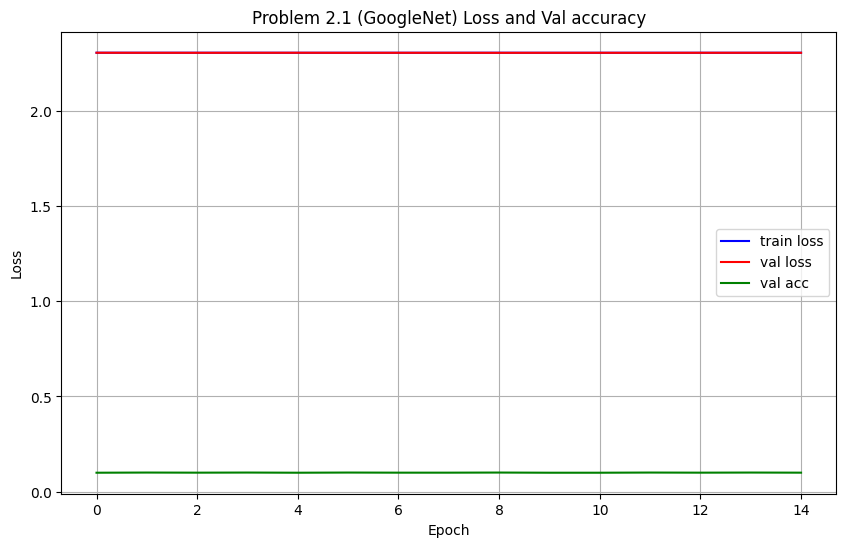

In [76]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 2.1 (GoogleNet) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [77]:
class GoogleNet():
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyBatchNorm2d(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b3(self):
        return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                            Inception(128, (128, 192), (32, 96), 64),
                            nn.LazyBatchNorm2d(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b4(self):
        return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                            Inception(160, (112, 224), (24, 64), 64),
                            Inception(128, (128, 256), (24, 64), 64),
                            Inception(112, (144, 288), (32, 64), 64),
                            Inception(256, (160, 320), (32, 128), 128),
                            nn.LazyBatchNorm2d(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self):
        return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                            Inception(384, (192, 384), (48, 128), 128),
                            nn.LazyBatchNorm2d(),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    def __init__(self, num_classes=10):
        self.model = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                                self.b5(), nn.LazyLinear(num_classes))

In [78]:
GN = GoogleNet()
model = GN.model
model.to(device)

Sequential(
  (0): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
      (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))

In [79]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 2.323674632765143 val: 2.927818930073149 val acc: 0.21596337854862213
 epoch[2] losses train: 1.7133200035985474 val: 2.2349572728393943 val acc: 0.28602707386016846
 epoch[3] losses train: 1.3741468135505686 val: 1.49019865853012 val acc: 0.44854697585105896
 epoch[4] losses train: 1.2037397527786167 val: 1.343592695369842 val acc: 0.521795392036438
 epoch[5] losses train: 1.0598245157152795 val: 1.139822773872667 val acc: 0.5915605425834656
 epoch[6] losses train: 0.9401028965745131 val: 1.27421380038474 val acc: 0.5607085824012756
 epoch[7] losses train: 0.8550094712497024 val: 0.9419516556581874 val acc: 0.6848129034042358
 epoch[8] losses train: 0.7818675658205891 val: 1.6230786864165287 val acc: 0.5384156107902527
 epoch[9] losses train: 0.7213342945136683 val: 1.0195379435636436 val acc: 0.6674960255622864
 epoch[10] losses train: 0.6659837361720516 val: 0.9358479460333563 val acc: 0.7021297812461853
 epoch[11] losses train: 0.6080891937017441 val: 0.9690

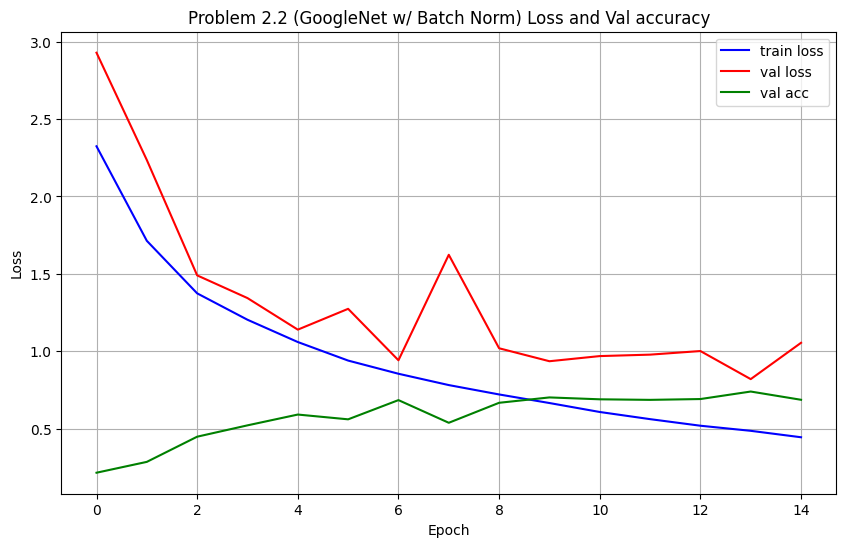

In [80]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 2.2 (GoogleNet w/ Batch Norm) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [ ]:
## Whilst still not a great model for this dataset, it at least learned something and was well above random guess accuracy that was acheived by the first model.

In [ ]:
##_________________________________________##
## Problem 3
##_________________________________________##

In [83]:
class Residual(nn.Module): 
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet():
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
    def __init__(self, arch, num_classes=10):
        self.model = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.model.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.model.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))

class ResNet18(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)

class ResNet26(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((4, 64), (4, 128), (4, 256), (4, 512)), num_classes)

class ResNet32(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((5, 64), (5, 128), (6, 256), (6, 512)), num_classes)

In [106]:
RN18 = ResNet18().model
RN18.to(device)
summary(RN18,(3,64,64))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022F304CFBE0>
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
          Residual-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
         Residual-14           [-1, 64,

In [107]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(RN18.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = RN18(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = RN18(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 1.6725922518831384 val: 1.869187659518734 val acc: 0.36813297867774963
 epoch[2] losses train: 1.142165724883604 val: 1.4833318367125883 val acc: 0.512042224407196
 epoch[3] losses train: 0.9171407596229593 val: 1.1444263454455479 val acc: 0.6163415908813477
 epoch[4] losses train: 0.7734715757924883 val: 1.0644473976390376 val acc: 0.6445063948631287
 epoch[5] losses train: 0.6521523157349023 val: 0.9367370290361392 val acc: 0.6899880766868591
 epoch[6] losses train: 0.5584649177997009 val: 1.1990210300038575 val acc: 0.6225119233131409
 epoch[7] losses train: 0.47220811266880813 val: 1.0359283112416602 val acc: 0.6819267868995667
 epoch[8] losses train: 0.4006138237007439 val: 1.1807344198986223 val acc: 0.6643112897872925
 epoch[9] losses train: 0.3316380886451515 val: 0.9239137427062746 val acc: 0.727707028388977
 epoch[10] losses train: 0.2752233141809321 val: 1.0238822842859159 val acc: 0.7109872698783875
 epoch[11] losses train: 0.22602359297663888 val: 0

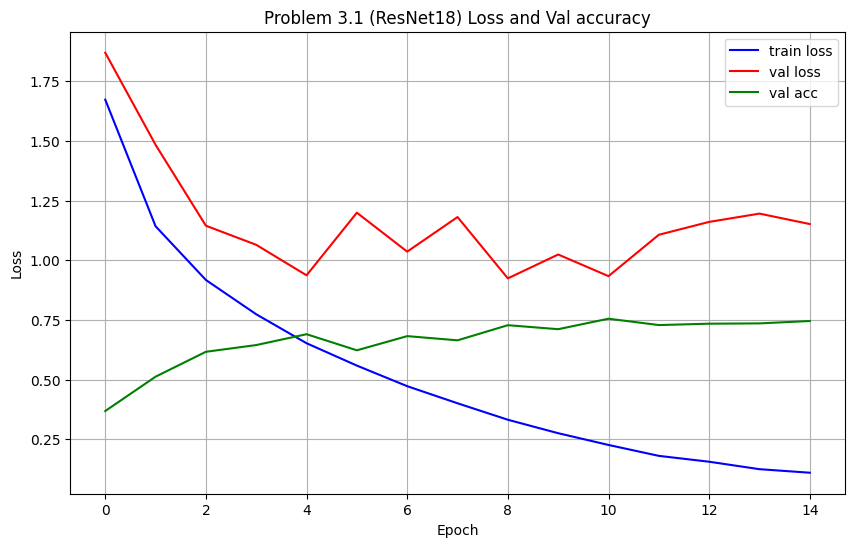

In [108]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 3.1 (ResNet18) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [103]:
RN26 = ResNet26().model
RN26.to(device)
summary(RN26,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
          Residual-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
         Residual-14           [-1, 64,

In [104]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(RN26.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = RN26(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = RN26(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 2.194044497921644 val: 2.252787188359886 val acc: 0.3052348792552948
 epoch[2] losses train: 1.6444620860507115 val: 1.9154524780382776 val acc: 0.3644506335258484
 epoch[3] losses train: 1.4249216970580314 val: 1.507197388418161 val acc: 0.5074641704559326
 epoch[4] losses train: 1.2745068981062115 val: 1.8488015634998394 val acc: 0.38903266191482544
 epoch[5] losses train: 1.1209391559023991 val: 1.1951542424548203 val acc: 0.5919585824012756
 epoch[6] losses train: 0.9991648529496644 val: 2.454315158212261 val acc: 0.2311902940273285
 epoch[7] losses train: 1.0406202379699863 val: 1.2753930080468487 val acc: 0.5955414175987244
 epoch[8] losses train: 0.8762359864571515 val: 1.7029389173361906 val acc: 0.5208997130393982
 epoch[9] losses train: 0.7881767634693009 val: 1.025041935170532 val acc: 0.6694864630699158
 epoch[10] losses train: 0.6981036010986704 val: 1.0172439464338265 val acc: 0.6621218323707581
 epoch[11] losses train: 0.6200789483002079 val: 1.07

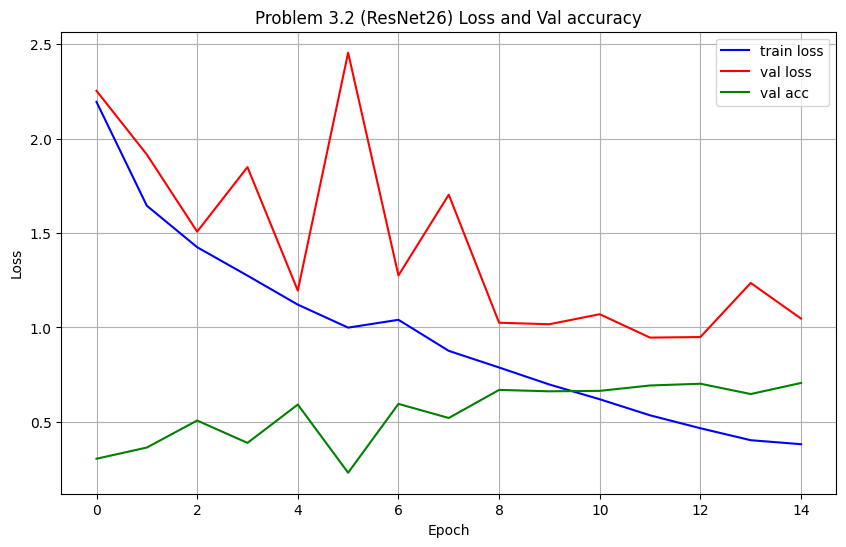

In [105]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 3.2 (ResNet26) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [95]:
RN32 = ResNet32().model
RN32.to(device)
summary(RN32,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7           [-1, 64, 16, 16]          36,928
       BatchNorm2d-8           [-1, 64, 16, 16]             128
          Residual-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
      BatchNorm2d-13           [-1, 64, 16, 16]             128
         Residual-14           [-1, 64,

In [96]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = optim.SGD(RN32.parameters(), lr=0.1)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = RN32(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = RN32(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=10).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

 epoch[1] losses train: 2.537165895447402 val: 3.0029433411397752 val acc: 0.15764331817626953
 epoch[2] losses train: 1.946578821562745 val: 2.2145534814543026 val acc: 0.2676154375076294
 epoch[3] losses train: 1.655354369479372 val: 9.37130317870219 val acc: 0.13355891406536102
 epoch[4] losses train: 1.5999669240563728 val: 3.2611471118441053 val acc: 0.19765128195285797
 epoch[5] losses train: 1.460124418253789 val: 1.8765907500200212 val acc: 0.36634156107902527
 epoch[6] losses train: 1.302372115880937 val: 1.3380542287401334 val acc: 0.5299562215805054
 epoch[7] losses train: 1.1943794826564886 val: 1.2827228789876222 val acc: 0.5568272471427917
 epoch[8] losses train: 1.0968980013257097 val: 1.2367263083245343 val acc: 0.5711584687232971
 epoch[9] losses train: 0.988873468716736 val: 1.2448572637928519 val acc: 0.5764331221580505
 epoch[10] losses train: 0.8969446248410607 val: 1.027939449450013 val acc: 0.6458001732826233
 epoch[11] losses train: 0.8224243678324058 val: 2.507

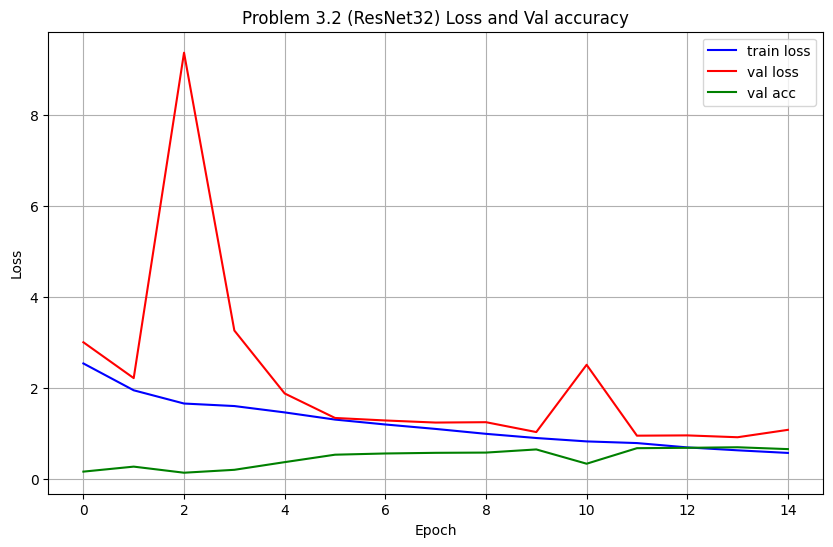

In [97]:
plt.plot(range(0, 15), train_loss_history, color='blue') 
plt.plot(range(0, 15), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,15):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 15), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('Problem 3.2 (ResNet32) Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [ ]:
## Of all the resnet models, ResNet 18 achieved the highest validation accuracy by a margin of 4 percentage points.